# 2021-04 NSF Training part 1

Outline 

1. The grants data model: key concepts
2. Getting publications by grants id, directorate, funder groups
3. Getting researcher awards, publications, patents, etc.
4. Finding similar awards/publications based on a given awards/publications
    
  

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli --quiet 

import dimcli
from dimcli.utils import *

import json
import sys
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML

print("==\nLogging in..")

ENDPOINT = "https://app.dimensions.ai"

if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)

dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.9)
Connected to: https://app.dimensions.ai - DSL v1.30
Method: dsl.ini file


## 1. The grants data model - quick walkthrough



Reference: https://docs.dimensions.ai/dsl/datasource-grants.html

### Dimensions IDs VS Original Grant IDs

In [25]:
%%dsldf

search grants 
    for "covid-19 OR coronavirus" 
return grants[id+grant_number+title] limit 5

Returned Grants: 5 (total = 8090)
Time: 0.55s


,title,id,grant_number
0,REU Site: The Stressed Life of Cells,grant.9606016,2051128
1,Towards the viable-decentralized supply chain,grant.9525993,198640
2,Annual meeting of the Swiss Society for Neuros...,grant.9526002,198908
3,Canonical and non-canonical secretory mechanis...,grant.8964419,894449
4,"Institutional Quality, State Intervention, and...",grant.9550210,SAB20-0064


If you have the IDs, you can search using them:

In [38]:
%%dsldf

search grants 
    where id in ["grant.9606016", "grant.9525993"]
    or grant_number in ["198908", "894449", "SAB20-0064"]
return grants[id+grant_number+title] 

Returned Grants: 5 (total = 5)
Time: 0.57s


,id,title,grant_number
0,grant.9606016,REU Site: The Stressed Life of Cells,2051128
1,grant.9525993,Towards the viable-decentralized supply chain,198640
2,grant.9526002,Annual meeting of the Swiss Society for Neuros...,198908
3,grant.8964419,Canonical and non-canonical secretory mechanis...,894449
4,grant.9550210,"Institutional Quality, State Intervention, and...",SAB20-0064


### Field types: 'Entity' (eg `funders`) VS atomic data type (`funding_org_name`) VS lists (`funder_countries`)

In [24]:
%%dsldf

search grants for "covid-19 OR coronavirus" 
return grants[id+funding_org_name+funder_countries] limit 5

Returned Grants: 5 (total = 8090)
Time: 0.57s


,id,funder_countries,funding_org_name
0,grant.9606016,"[{'id': 'US', 'name': 'United States'}]",Directorate for Biological Sciences
1,grant.9525993,"[{'id': 'CH', 'name': 'Switzerland'}]",Swiss National Science Foundation
2,grant.9526002,"[{'id': 'CH', 'name': 'Switzerland'}]",Swiss National Science Foundation
3,grant.8964419,"[{'id': 'BE', 'name': 'Belgium'}]",European Commission
4,grant.9550210,"[{'id': 'SE', 'name': 'Sweden'}]",Bank of Sweden Tercentenary Foundation


Use `unnest(funders)` to unpack the contents of that field (docs:https://docs.dimensions.ai/dsl/language.html#unnesting-multi-value-entity-fields)

In [39]:
%%dsldf

search grants for "covid-19 OR coronavirus" return grants[id+funders] limit 5

Returned Grants: 5 (total = 8090)
Time: 0.62s


,id,funders
0,grant.9606016,"[{'id': 'grid.457768.f', 'types': ['Government..."
1,grant.9525993,"[{'id': 'grid.425888.b', 'types': ['Government..."
2,grant.9526002,"[{'id': 'grid.425888.b', 'types': ['Government..."
3,grant.8964419,"[{'id': 'grid.270680.b', 'types': ['Government..."
4,grant.9550210,"[{'id': 'grid.454174.7', 'types': ['Nonprofit'..."


### Filtering using entity properties (eg `funders.id`)

Caveat: entity filters are resolved via a 'subquery' and are better used only with identifiers or properties matching a small number of results. 
See also https://docs.dimensions.ai/dsl/language.html#literal-fields-vs-entity-fields

In [33]:
%%dsldf

search grants for "covid-19 OR coronavirus" 
where funders.id = "grid.425888.b"
return grants limit 5

Returned Grants: 5 (total = 91)
Time: 0.60s


,start_year,active_year,title_language,id,language,project_num,funding_org_name,end_date,start_date,title,funders,original_title
0,2021,"[2021, 2022]",en,grant.9525993,en,198640,Swiss National Science Foundation,2022-01-31,2021-12-01,Towards the viable-decentralized supply chain,"[{'id': 'grid.425888.b', 'name': 'Swiss Nation...",Towards the viable-decentralized supply chain
1,2021,"[2021, 2022]",en,grant.9526002,en,198908,Swiss National Science Foundation,2022-02-28,2021-12-01,Annual meeting of the Swiss Society for Neuros...,"[{'id': 'grid.425888.b', 'name': 'Swiss Nation...",Annual meeting of the Swiss Society for Neuros...
2,2021,"[2021, 2022]",en,grant.9556723,en,199262,Swiss National Science Foundation,2022-08-31,2021-03-01,The mechanism and impact of heterogeneity in a...,"[{'id': 'grid.425888.b', 'name': 'Swiss Nation...",The mechanism and impact of heterogeneity in a...
3,2021,[2021],en,grant.9556760,en,201312,Swiss National Science Foundation,2021-07-31,2021-02-01,Research semester,"[{'id': 'grid.425888.b', 'name': 'Swiss Nation...",Research semester
4,2021,"[2021, 2022]",en,grant.9556673,en,196906,Swiss National Science Foundation,2022-12-31,2021-01-01,A Systematic Assessment of the Drivers of COVI...,"[{'id': 'grid.425888.b', 'name': 'Swiss Nation...",A Systematic Assessment of the Drivers of COVI...


### Getting grants for a funder 'group', as defined in Dimensions

* Funder 'group' ie NSF: usually consists of more than one GRID identifier. These can be obtained from the webapp. 
    * https://app.dimensions.ai/browse/facet-filter-groups/publication
* Division or Program: should be tackled via specific grants IDs  

In [40]:
pd.read_csv("Dimensions-My-groups-2021-04-07_08-05-49.csv")

,Filter type,Group,Name,ID
0,Funder,NSF-mine,Directorate for Biological Sciences (NSF BIO),grid.457768.f
1,Funder,NSF-mine,Directorate for Computer & Information Science...,grid.457785.c
2,Funder,NSF-mine,Directorate for Education & Human Resources (N...,grid.457799.1
3,Funder,NSF-mine,Directorate for Engineering (NSF ENG),grid.457810.f
4,Funder,NSF-mine,Directorate for Geosciences (NSF GEO),grid.457836.b
5,Funder,NSF-mine,Directorate for Mathematical & Physical Scienc...,grid.457875.c
6,Funder,NSF-mine,"Directorate for Social, Behavioral & Economic ...",grid.457916.8
7,Funder,NSF-mine,Division of Advanced Cyberinfrastructure (NSF ...,grid.457789.0
8,Funder,NSF-mine,"Division of Chemical, Bioengineering, Environm...",grid.457813.c
9,Funder,NSF-mine,"Division of Civil, Mechanical & Manufacturing ...",grid.457814.b


Let's get the GRID IDs for the NSF and put them into a Python list

In [44]:
nsfgrids = pd.read_csv("Dimensions-My-groups-2021-04-07_08-05-49.csv")['ID'].to_list()

Then we can generate query programmatically using this list. 

The total number of results should match [what you see in Dimensions](https://app.dimensions.ai/discover/publication?and_facet_funder_shared_group_facet=574603a4-0c27-4844-9f74-7e6810e25cfb).

For background on this topic, see the [Working with lists in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html) tutorial.

In [92]:
import json

query = f"""
search grants 
    where funders.id in {json.dumps(nsfgrids)}
return grants[id+title]
"""

grants = dsl.query(query)
grants.as_dataframe()

Returned Grants: 20 (total = 532277)
Time: 0.66s


,title,id
0,REU Site: The Stressed Life of Cells,grant.9606016
1,CAREER: Sculpting light in biological tissue: ...,grant.9605752
2,CAREER: Achieving Real-Time Machine Learning w...,grant.9605878
3,FAI: Quantifying and Mitigating Disparities in...,grant.9605613
4,Doctoral Dissertation Research: Innovating Hou...,grant.9605932
5,SaTC: CORE: Small: Automatic Exploits Detectio...,grant.9606024
6,CRII: CIF: Machine Learning Based Equalization...,grant.9606076
7,SWIFT: SMALL: Interference Canceling for Impro...,grant.9398792
8,CAREER: Innovative Technology for Mass Timber ...,grant.9522805
9,CAREER: Leveraging Signal Structure for Cost-S...,grant.9549632


### From grants to other entities: links overview

In [88]:
Image(url= "https://docs.dimensions.ai/dsl/_images/data-model-overview-1.png", width=1000)

## 2. Getting publications from Grants


### Starting from Dimensions grant IDs

First let's retrieve a sample set of NSF grants from Dimensions

In [99]:

query = f"""
search grants 
    for "quantum leap" 
    where funders.id in {json.dumps(nsfgrids)}
    and active_year <= 2018 
return grants[id+title]
"""

grants = dsl.query(query)
grants.as_dataframe()


Returned Grants: 20 (total = 143)
Time: 0.75s


,id,title
0,grant.7874106,Enabling Quantum Leap: Convergent Approach to ...
1,grant.7672698,EAGER: Enabling Quantum Leap: Topological Nano...
2,grant.7733433,"RAISE: TAQS: Engineering high quality, practic..."
3,grant.7705359,MRI: Acquisition of a High Performance Compute...
4,grant.7734719,Collaborative Research: Atomic Displacement En...
5,grant.7734848,Collaborative Research: Atomic Displacement En...
6,grant.7672619,QLC: EAGER: Harnessing molecular conformationa...
7,grant.7703303,Photoresponsive Vinyl Azide Crystals
8,grant.7706507,First-Principles Design of Charged Defects for...
9,grant.7672113,EAGER: Enabling Quantum Leap: Room-temperature...


Now we can use the IDs to retrieve all resulting publications.

NOTE: the direction of the search is from publications to grants, using the `supporting_grant_ids` field.


In [100]:
grantids = grants.as_dataframe()['id'].to_list()

query = f"""search publications
          where supporting_grant_ids in {json.dumps(grantids)}
       return publications[title+doi+year+supporting_grant_ids]"""

pubs = dsl.query(query).as_dataframe()
pubs


Returned Publications: 20 (total = 113)
Time: 0.60s


,year,supporting_grant_ids,doi,title
0,2021,[grant.7704662],10.1016/j.nuclphysb.2021.115373,Universal entanglement of mid-spectrum eigenst...
1,2021,[grant.7704662],10.1038/s41578-021-00292-1,Materials challenges for trapped-ion quantum c...
2,2021,"[grant.8659303, grant.7672113]",10.1021/acs.nanolett.0c04282,Site-Controlled Quantum Emitters in Monolayer ...
3,2021,"[grant.7704662, grant.5544205, grant.8541793]",10.1103/physrevlett.126.090505,Quantum Computational Advantage with String Or...
4,2021,"[grant.8541353, grant.7705359, grant.3142576]",10.3847/1538-4357/abd859,On the Origin of Solar Hemispherical Helicity ...
5,2021,[grant.7706507],10.1088/1361-648x/abeacf,Substrate Effect on Excitonic Shift and Radiat...
6,2021,[grant.7425335],10.1016/j.apsusc.2020.148461,First-principles studies of MoF6 absorption on...
7,2021,"[grant.7070570, grant.8522863, grant.9046815, ...",10.1021/acs.jpca.0c08953,From Incident Light to Persistent and Regenera...
8,2021,"[grant.7704662, grant.7438079, grant.3982512]",10.1145/3436752,Using Spectral Graph Theory to Map Qubits onto...
9,2021,[grant.7705359],10.1016/j.jcp.2020.110063,A single-step third-order temporal discretizat...


### Starting from funders IDs

There is a direct link from Publications to funders, so we can use it to quickly identify publications of interest. 

In [109]:
query = f"""
search publications 
    for "quantum leap" 
    where funders.id in {json.dumps(nsfgrids)}
return publications[id+title+year+unnest(supporting_grant_ids)]
"""

pubs = dsl.query(query).as_dataframe()
pubs

Returned objects: 86 (total publications= 960)
Time: 0.64s


,title,id,year,supporting_grant_ids
0,Ordering effects on deformation substructures ...,pub.1136651843,2021,grant.8541247
1,Ordering effects on deformation substructures ...,pub.1136651843,2021,grant.3489473
2,Central vortex steady states and dynamics of B...,pub.1135145104,2021,grant.7070570
3,Central vortex steady states and dynamics of B...,pub.1135145104,2021,grant.9381488
4,Central vortex steady states and dynamics of B...,pub.1135145104,2021,grant.8132165
...,...,...,...,...
81,Early defect identification for micro light‐em...,pub.1135163727,2021,grant.8567538
82,Nucleon axial and pseudoscalar form factors fr...,pub.1135670031,2021,grant.8659119
83,Nucleon axial and pseudoscalar form factors fr...,pub.1135670031,2021,grant.6439196
84,Nucleon axial and pseudoscalar form factors fr...,pub.1135670031,2021,grant.7031622


Now we can retrieve the associated grants. 




In [114]:
grantids = pubs['supporting_grant_ids'].to_list()

query = f"""
search grants 
    where id in {json.dumps(grantids)}
return grants[id+title+funders]
"""

linkedgrants = dsl.query(query).as_dataframe()
linkedgrants

Returned Grants: 20 (total = 83)
Time: 0.92s


,title,funders,id
0,Collaborative Research: CIF: Medium: Security ...,"[{'id': 'grid.457785.c', 'name': 'Directorate ...",grant.9381525
1,CNS Core: Small: Harnessing Wireless Actuation,"[{'id': 'grid.457785.c', 'name': 'Directorate ...",grant.9397686
2,CIF: Small: Alpha Loss: A New Framework for Un...,"[{'id': 'grid.457785.c', 'name': 'Directorate ...",grant.9397682
3,SWIFT: LARGE: Averting Wireless Spectrum Pollu...,"[{'id': 'grid.457810.f', 'name': 'Directorate ...",grant.9398808
4,QLCI-CI: NSF Quantum Leap Challenge Institute ...,"[{'id': 'grid.457875.c', 'name': 'Directorate ...",grant.9382459
5,Design and Analysis of Highly Efficient Algori...,"[{'id': 'grid.457875.c', 'name': 'Directorate ...",grant.9382289
6,Excellence in Research: Research in Machine Le...,"[{'id': 'grid.457875.c', 'name': 'Directorate ...",grant.9381488
7,Point of Anchor: Impacts on Interfacial Charge...,"[{'id': 'grid.457875.c', 'name': 'Directorate ...",grant.9313461
8,The Role of DNA dynamics in damage recognition,"[{'id': 'grid.418100.c', 'name': 'Biotechnolog...",grant.8857516
9,Dynamics of sudden suppression of topological ...,"[{'id': 'grid.436846.b', 'name': 'National Sci...",grant.9334162


### More learning resources

* [Enriching Grants part 2: Adding Publications Information from Dimensions](https://api-lab.dimensions.ai/cookbooks/3-grants/2-grants-enrichment-adding-publications-information.html#)
* [Working with longs lists of IDs](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html#5.-How-Long-can-lists-get?)

## 3. Getting researcher awards, publications, patents 

Let's start by retrieving a list of recently NSF-awarded researchers on Covid-19 related topics. We can use a facet query to quickly get this data.

Note: by default, the `researchers` facet returns records sorted by number of associated grants. 

In [53]:
COVID_Q = '"2019-nCoV" OR "COVID-19" OR "SARS-CoV-2" OR "HCoV-2019" OR "hcov" OR "NCOVID-19" OR  "severe acute respiratory syndrome coronavirus 2" OR "severe acute respiratory syndrome corona virus 2" OR "coronavirus disease 2019" OR (("coronavirus"  OR "corona virus") AND (Wuhan OR China OR novel))'


query = f"""
search grants 
    for "{dsl_escape(COVID_Q)}"
    where funders.id in {json.dumps(nsfgrids)}
    and active_year >= 2020
return researchers[id+first_name+last_name+dimensions_url]
"""

researchers = dsl.query(query).as_dataframe()
researchers

Returned Researchers: 20
Time: 0.59s


,id,count,first_name,dimensions_url,last_name
0,ur.015320046213.35,3,Yanfang,https://app.dimensions.ai/discover/publication...,Ye
1,ur.0771415054.83,3,Ioannis A,https://app.dimensions.ai/discover/publication...,Kakadiaris
2,ur.01026705233.54,2,Kapil Chalil,https://app.dimensions.ai/discover/publication...,Madathil
3,ur.01033456147.69,2,Philip A,https://app.dimensions.ai/discover/publication...,Gable
4,ur.01052213267.35,2,Katriona,https://app.dimensions.ai/discover/publication...,Shea
5,ur.010575472101.85,2,Debra Fern,https://app.dimensions.ai/discover/publication...,Laefer
6,ur.01060704061.65,2,Mindy Krischer,https://app.dimensions.ai/discover/publication...,Shoss
7,ur.01062572075.16,2,Reza Arman,https://app.dimensions.ai/discover/publication...,Ghiladi
8,ur.010667213217.14,2,Rob A,https://app.dimensions.ai/discover/publication...,Deleo
9,ur.010700017517.23,2,Shuai,https://app.dimensions.ai/discover/publication...,Li


Dimcli includes a function to quickly export a dataframe to google sheets ([documentation](https://digital-science.github.io/dimcli/modules.html#dimcli.utils.misc_utils.export_as_gsheets)). 

This is often handy to further analysing or for sharing the data.

In [54]:
export_as_gsheets(researchers)

..authorizing with google..
..creating a google sheet..
..uploading..


'https://docs.google.com/spreadsheets/d/15oO_8JZeYnUoulXJE7-eqOa9M7smKaEIMTl_IK7-Q9M'

### Awards

You can select any number of researcher IDs and retrieve related data. 

Tips 
* If we `return grants` we get the full grant details  
* If we `return funders` we can get a quick overview of who's funding these researchers.

In [79]:
focus = researchers['id'][:1].to_list()

In [83]:
query = f"""
search grants 
    where researchers.id in {json.dumps(focus)}
return grants[title+active_year+id+language+grant_number+funding_org_name+researchers]
"""

awards = dsl.query(query).as_dataframe()
awards

Returned Grants: 12 (total = 12)
Time: 0.59s


,active_year,grant_number,researchers,title,id,language,funding_org_name
0,"[2020, 2021]",2026612,"[{'id': 'ur.011726261641.36', 'last_name': 'Yu...",FW-HTF-P: Distributed Intelligent Assistant to...,grant.9398642,en,Directorate for Engineering
1,"[2020, 2021, 2022]",2040144,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",EAGER: An AI-driven Paradigm for Collective an...,grant.9383872,en,Directorate for Computer & Information Science...
2,"[2020, 2021]",2034470,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",RAPID: AI-driven Innovations for COVID-19 Them...,grant.9313236,en,Directorate for Computer & Information Science...
3,"[2020, 2021]",2027127,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",RAPID: AI- and Data-driven Integrated Framewor...,grant.9067270,en,Directorate for Computer & Information Science...
4,[2019],1908215,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",III: Small: Mining Heterogeneous Network Built...,grant.8567640,en,Directorate for Computer & Information Science...
5,"[2019, 2020, 2021, 2022]",1951504,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",III: Small: Mining Heterogeneous Network Built...,grant.8635076,en,Directorate for Computer & Information Science...
6,"[2019, 2020]",1946327,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",TWC: Small: Intelligent Malware Detection Util...,grant.8674944,en,Directorate for Computer & Information Science...
7,"[2019, 2020, 2021, 2022, 2023, 2024]",1940859,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",CAREER: Securing Cyberspace: Gaining Deep Insi...,grant.8540674,en,Directorate for Computer & Information Science...
8,"[2019, 2020, 2021]",1940855,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",CICI: SSC: SciTrust: Enhancing Security for Mo...,grant.8635104,en,Directorate for Computer & Information Science...
9,[2019],1845138,"[{'id': 'ur.015320046213.35', 'last_name': 'Ye...",CAREER: Securing Cyberspace: Gaining Deep Insi...,grant.8382455,en,Directorate for Computer & Information Science...


### Publications


In [58]:
focus = researchers['id'][:1].to_list()

Let's get recent publications:

In [65]:

query = f"""
search publications 
    where researchers.id in {json.dumps(focus)}
    and year > 2015
return publications[id+year+authors_count+title+type+journal+field_citation_ratio+times_cited+supporting_grant_ids+funders]
sort by times_cited limit 10
"""

pubs = dsl.query(query).as_dataframe()
pubs

Returned Publications: 10 (total = 52)
Time: 0.60s


,year,authors_count,field_citation_ratio,title,type,supporting_grant_ids,id,times_cited,funders,journal.id,journal.title
0,2017,4,73.95,A Survey on Malware Detection Using Data Minin...,article,"[grant.3935090, grant.8374180, grant.3479555, ...",pub.1090311679,163,"[{'id': 'grid.457785.c', 'types': ['Government...",jour.1119907,ACM Computing Surveys
1,2019,7,128.38,Heterogeneous Graph Attention Network,proceeding,NaN,pub.1114205838,127,NaN,NaN,NaN
2,2017,4,38.13,HinDroid,proceeding,[grant.5543433],pub.1091105361,85,"[{'id': 'grid.457785.c', 'types': ['Government...",NaN,NaN
3,2016,4,29.90,Deep4MalDroid: A Deep Learning Framework for A...,proceeding,[grant.5543433],pub.1093330020,74,"[{'id': 'grid.457785.c', 'types': ['Government...",NaN,NaN
4,2016,3,24.86,Malicious sequential pattern mining for automa...,article,[grant.7023327],pub.1048693282,65,"[{'id': 'grid.419696.5', 'types': ['Government...",jour.1128045,Expert Systems with Applications
5,2016,4,13.86,DroidDelver: An Android Malware Detection Syst...,chapter,NaN,pub.1002478143,36,NaN,NaN,NaN
6,2017,5,16.48,DeepAM: a heterogeneous deep learning framewor...,article,[grant.5543433],pub.1085221850,35,"[{'id': 'grid.457785.c', 'types': ['Government...",jour.1041769,Knowledge and Information Systems
7,2017,3,13.46,SecureDroid,proceeding,[grant.5543433],pub.1099595723,30,"[{'id': 'grid.457785.c', 'types': ['Government...",NaN,NaN
8,2018,5,13.19,Gotcha - Sly Malware!,proceeding,[grant.5543433],pub.1105723512,22,"[{'id': 'grid.457785.c', 'types': ['Government...",NaN,NaN
9,2016,7,8.42,Automatic Detection of Helmet Uses for Constru...,proceeding,NaN,pub.1095272357,22,"[{'id': 'grid.416809.2', 'types': ['Facility']...",NaN,NaN


### Patents

In [67]:
focus = researchers['id'][:10].to_list()

In [72]:
query = f"""
search patents 
    where researchers.id in {json.dumps(focus)}
return patents[basics+researchers+dimensions_url] 
limit 10

"""

patents = dsl.query(query).as_dataframe()
patents

Returned Patents: 10 (total = 20)
Time: 0.64s


,year,assignee_names,filing_status,inventor_names,researchers,title,dimensions_url,assignees,id,publication_date,times_cited,granted_year
0,2014,[UNIV HOUSTON SYSTEM],Application,"[KAKADIARIS IOANNIS A, MOUTAFIS PANAGIOTIS]","[{'id': 'ur.0771415054.83', 'last_name': 'Kaka...",A RANK-BASED SCORE NORMALIZATION FRAMEWORK AND...,https://app.dimensions.ai/details/patent/WO-20...,"[{'id': 'grid.187082.4', 'types': ['Education'...",WO-2014145698-A1,2014-09-18,0,NaN
1,2004,"[BOARD OF REGENTS, University of Houston]",Application,"[KAKADIARIS IOANNIS, THEOHARIS THEOHARIS]","[{'id': 'ur.0771415054.83', 'last_name': 'Kaka...",Multi-modal face recognition,https://app.dimensions.ai/details/patent/US-20...,"[{'id': 'grid.266436.3', 'types': ['Education'...",US-20050084140-A1,2005-04-21,47,NaN
2,2004,"[THEOHARIS THEOHARIS, UNIV HOUSTON, KAKADIARIS...",Application,"[KAKADIARIS IOANNIS, THEOHARIS THEOHARIS]","[{'id': 'ur.0771415054.83', 'last_name': 'Kaka...",MULTI-MODAL FACE RECOGNITION,https://app.dimensions.ai/details/patent/WO-20...,"[{'id': 'grid.266436.3', 'types': ['Education'...",WO-2005020030-A3,2005-04-07,0,NaN
3,2004,"[THEOHARIS THEOHARIS, UNIV HOUSTON, KAKADIARIS...",Application,"[KAKADIARIS IOANNIS, THEOHARIS THEOHARIS]","[{'id': 'ur.0771415054.83', 'last_name': 'Kaka...",MULTI-MODAL FACE RECOGNITION,https://app.dimensions.ai/details/patent/WO-20...,"[{'id': 'grid.266436.3', 'types': ['Education'...",WO-2005020030-A2,2005-03-03,0,NaN
4,2004,"[BOARD OF REGENTS, University of Houston]",Grant,"[KAKADIARIS IOANNIS, THEOHARIS THEOHARIS]","[{'id': 'ur.0771415054.83', 'last_name': 'Kaka...",Multi-modal face recognition,https://app.dimensions.ai/details/patent/US-75...,"[{'id': 'grid.266436.3', 'types': ['Education'...",US-7512255-B2,2009-03-31,17,2009.0
5,2014,[University of Houston System],Grant,"[MOUTAFIS PANAGIOTIS, KAKADIARIS IOANNIS A]","[{'id': 'ur.0771415054.83', 'last_name': 'Kaka...",Rank-based score normalization framework and m...,https://app.dimensions.ai/details/patent/US-10...,"[{'id': 'grid.187082.4', 'types': ['Education'...",US-10235344-B2,2019-03-19,1,2019.0
6,2018,[UNIV COLLEGE DUBLIN NAT UNIV IRELAND DUBLIN],Application,"[AL-SABAH SALAM, LAEFER DEBRA FERN]","[{'id': 'ur.07470163250.71', 'last_name': 'Al-...",STRUCTURAL MEMBER,https://app.dimensions.ai/details/patent/WO-20...,"[{'id': 'grid.7886.1', 'types': ['Education'],...",WO-2019092286-A1,2019-05-16,0,NaN
7,2003,"[University of Houston System, Iowa State Univ...",Grant,"[KOURI DONALD K, HOFFMAN DAVID K, ARNOLD MARK,...","[{'id': 'ur.01043305330.38', 'last_name': 'Kou...",Methods for performing DAF data filtering and ...,https://app.dimensions.ai/details/patent/US-72...,"[{'id': 'grid.34421.30', 'types': ['Education'...",US-7272265-B2,2007-09-18,122,2007.0
8,1999,"[University of Houston System, Iowa State Univ...",Grant,"[KOURI DONALD J, HOFFMAN DAVID K, KAKADIARIS I...","[{'id': 'ur.01043305330.38', 'last_name': 'Kou...",Methods for performing DAF data filtering and ...,https://app.dimensions.ai/details/patent/US-68...,"[{'id': 'grid.187082.4', 'types': ['Education'...",US-6847737-B1,2005-01-25,192,2005.0
9,2018,"[UNIV COLLEGE DUBLIN NAT UNIV IRELAND DUBLIN, ...",Application,"[AL-SABAH SALAM, LAEFER DEBRA FERN]","[{'id': 'ur.07470163250.71', 'last_name': 'Al-...",STRUCTURAL MEMBER,https://app.dimensions.ai/details/patent/US-20...,"[{'id': 'grid.7886.1', 'types': ['Education'],...",US-20200378107-A1,2020-12-03,0,NaN


In [73]:
export_as_gsheets(patents)

..authorizing with google..
..creating a google sheet..
..uploading..


'https://docs.google.com/spreadsheets/d/1qi4Pzm0iLwEdGh_Hz9kklQlR-qZu0VQAX8Bb-ChfOv0'

### More learning resources

* [Enriching Grants part 3: adding related Patents and Clinical Trials data](https://api-lab.dimensions.ai/cookbooks/3-grants/3-grants-enrichment-adding-patents-cltrials-information.html)
* [Retrieve all grants funding publications ](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html#9.-Patents-example-(patents--%3E-publications))

## 4. Finding similar awards / publications

The procedure is similar for both grants and publications. It involves extracting concepts and then using those concepts to find related records. 
    
Let's generate a sample dataset of NSF grants on 'quantum leap'. NOTE this time the DSL query includes also the field `concepts_scores`.  

For background, see also the [Working with concepts in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/7-Working-with-concepts.html) tutorial.
    

In [133]:
query = f"""
search grants 
    for "quantum leap" 
    where funders.id in {json.dumps(nsfgrids)}
    and active_year >= 2015 
return grants[id+title+concepts_scores] limit 1000
"""

grants = dsl.query(query)
grants.as_dataframe()

Returned Grants: 162 (total = 162)
Time: 1.19s


,id,concepts_scores,title
0,grant.9522833,[{'concept': 'two-dimensional topological mate...,CAREER: Scalable Nanomanufacturing of Two-Dime...
1,grant.9455596,[{'concept': 'Cornell High Energy Synchrotron ...,Mid-scale RI-2: A first-of-its-kind X-ray faci...
2,grant.9398686,"[{'concept': 'new software abstraction', 'rele...",PPoSS: Planning: THINGULARITY- Taming the Hete...
3,grant.9382743,"[{'concept': 'quantum technologies', 'relevanc...",Collaborative Research: AccelNet: Global Quant...
4,grant.9382744,"[{'concept': 'quantum technologies', 'relevanc...",Collaborative Research: AccelNet: Global Quant...
...,...,...,...
157,grant.3128420,"[{'concept': 'material modification', 'relevan...",MRI: Development of a Versatile High Energy Re...
158,grant.3128904,"[{'concept': 'sea surface salinity', 'relevanc...",Long Term Salinity Measurements
159,grant.3126824,"[{'concept': 'human-computer interface', 'rele...",HCC: Small: Assistive Social Situational Aware...
160,grant.2999366,"[{'concept': 'software pipeline', 'relevance':...",Collaborative Research: Booming or Beaming? So...


We then 'explode' the concepts data so to remove nested values

In [134]:
concepts = grants.as_dataframe_concepts()
concepts

,id,title,concepts_count,concept,score,frequency,score_avg
0,grant.9522833,CAREER: Scalable Nanomanufacturing of Two-Dime...,153,two-dimensional topological materials,0.733,1,0.73300
1,grant.9522833,CAREER: Scalable Nanomanufacturing of Two-Dime...,153,continuous flow process,0.711,1,0.71100
2,grant.9522833,CAREER: Scalable Nanomanufacturing of Two-Dime...,153,flow processes,0.707,1,0.70700
3,grant.9522833,CAREER: Scalable Nanomanufacturing of Two-Dime...,153,device applications,0.678,3,0.58700
4,grant.9522833,CAREER: Scalable Nanomanufacturing of Two-Dime...,153,energy-efficient electronics,0.674,3,0.47733
...,...,...,...,...,...,...,...
20507,grant.3057561,Collaborative Research on the Iceland Deep Dri...,123,funds,0.105,2,0.10650
20508,grant.3057561,Collaborative Research on the Iceland Deep Dri...,123,participation,0.098,23,0.10604
20509,grant.3057561,Collaborative Research on the Iceland Deep Dri...,123,smokers,0.068,1,0.06800
20510,grant.3057561,Collaborative Research on the Iceland Deep Dri...,123,elders,0.059,1,0.05900


In [135]:
concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg']]
concepts_unique

,concept,frequency,score_avg
0,two-dimensional topological materials,1,0.73300
1,continuous flow process,1,0.71100
2,flow processes,1,0.70700
3,device applications,3,0.58700
4,energy-efficient electronics,3,0.47733
...,...,...,...
20499,Power Company,1,0.18000
20504,handling,1,0.12700
20509,smokers,1,0.06800
20510,elders,1,0.05900


We can use the plotly visualization library to explore the concepts:

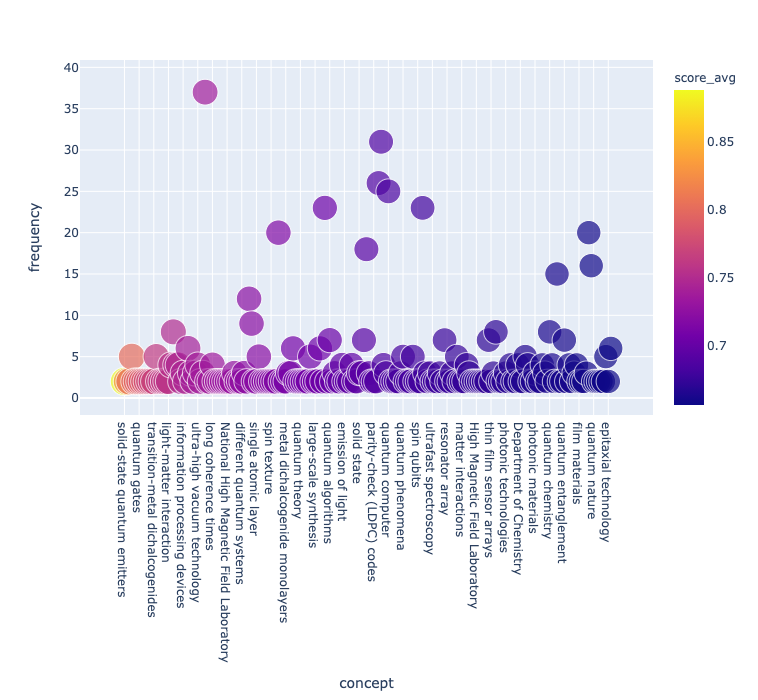

In [136]:
import plotly.express as px

FREQ_MIN = 2 
FREQ_MAX = 70 
SCORE_MIN = 0.6 
MAX_CONCEPTS = 200 

filtered_concepts = concepts_unique.query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)[:MAX_CONCEPTS]

px.scatter(filtered_concepts,
           x="concept",
           y="frequency",
           height=700,
           color="score_avg",
           size="score_avg")


Let's get a subset of those concepts to find 'similar' grants. 

In [138]:
focusconcepts = concepts_unique.query(f"""frequency >= 3 & frequency <= 20 & score_avg >= 0.7 """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)
focusconcepts

,concept,frequency,score_avg
14317,second quantum revolution,5,0.80080
5400,single-photon emitters,5,0.76280
6878,topological insulators,4,0.75425
2779,quantum information processing,8,0.75025
1510,neutron stars,4,0.74925
12082,exciton states,4,0.74875
11639,information processing devices,3,0.74500
10397,quantum emitters,6,0.74017
5816,quantum photonic technologies,3,0.74000
3135,quantum information technology,3,0.73900


In [145]:
names = focusconcepts['concept'].to_list()

q_focusconcepts = " OR ".join(['"%s"' % x for x in names])


query = f"""
search grants 
    in concepts 
    for "{dsl_escape(q_focusconcepts)}" 
    where active_year >= 2015
    not funders.id in {json.dumps(nsfgrids)}
return grants[id+title+funding_org_name] limit 1000
"""

print(query)

grants = dsl.query(query)
grants.as_dataframe()


search grants 
    in concepts 
    for "\"second quantum revolution\" OR \"single-photon emitters\" OR \"topological insulators\" OR \"quantum information processing\" OR \"neutron stars\" OR \"exciton states\" OR \"information processing devices\" OR \"quantum emitters\" OR \"quantum photonic technologies\" OR \"quantum information technology\" OR \"ultra-high vacuum technology\" OR \"atomic species\" OR \"long coherence times\" OR \"cavity quantum electrodynamics\" OR \"quantum particle\" OR \"quantum mechanics\" OR \"two-dimensional materials\" OR \"quantum coherence\" OR \"quantum systems\" OR \"semiconductor heterostructures\" OR \"mathematical physics\" OR \"quantum optics\" OR \"quantum information community\" OR \"coherence time\" OR \"quantum algorithms\"" 
    where active_year >= 2015
    not funders.id in ["grid.457768.f", "grid.457785.c", "grid.457799.1", "grid.457810.f", "grid.457836.b", "grid.457875.c", "grid.457916.8", "grid.457789.0", "grid.457813.c", "grid.457814.b"

,title,funding_org_name,id
0,Simulating ultracold correlated quantum matter...,European Research Council,grant.9414093
1,Nuclear Theory from First Principles,European Research Council,grant.9523059
2,Atomic Quantum Emitters in 2D Frameworks,European Research Council,grant.9488337
3,Entropy for Quantum Information Science,European Research Council,grant.9488556
4,Gravitational-wave data mining,European Research Council,grant.9413940
...,...,...,...
995,Quantum Information Learning,European Commission,grant.8586452
996,Long-range coherence in nanosystems,Academy of Finland,grant.8838094
997,Exact Solutions of strongly interacting Models...,German Research Foundation,grant.9142999
998,Levitated Cavity Optomechanics,German Research Foundation,grant.8858784


Returned Funders: 20
Time: 0.63s


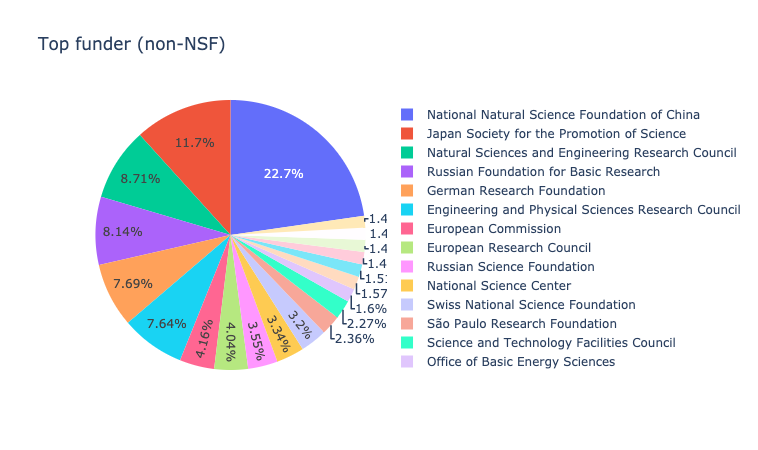

In [147]:
query = f"""
search grants 
    in concepts 
    for "{dsl_escape(q_focusconcepts)}" 
    where active_year >= 2015
    not funders.id in {json.dumps(nsfgrids)}
return funders
"""

grants = dsl.query(query).as_dataframe()

px.pie(grants,
       names='name', values="count",
      title = "Top funders (non-NSF)")

### More learning resources

* [Working with concepts in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/7-Working-with-concepts.html)
* [Building a concepts co-occurence network](https://api-lab.dimensions.ai/cookbooks/2-publications/Concepts-network-graph.html)
* [Identifying emerging topics in grants using ‘concepts’](https://api-lab.dimensions.ai/cookbooks/3-grants/4-grants-topic-analysis.html)